### Libraries

In [1]:
import os
from PIL import Image
import time
import datetime
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import timm
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.models import convnext_base
from collections import Counter
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
import torch
from torch.utils.data import Dataset
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/shokoo/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4112726/2841373004.py:21: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [2]:
pwd

'/home/shokoo/EchoView/view_classification/notebooks/models'

In [3]:
dataset_address = '/home/shokoo/EchoView/Datasets/data_split/'
files_address = '/home/shokoo/EchoView/view_classification'

In [4]:
paths = glob.glob(os.path.join(dataset_address + '**/*/*', '*')) #numebr of all samples per patients
len(paths)

665299

In [5]:
avg_data_mean = np.array([0.0847569 , 0.08113708, 0.08339239])
avg_data_std = np.array([0.17340048, 0.17009241, 0.17395345])

### Load the csv file containing the image file names and corresponding labels

In [6]:
info_train = pd.read_csv(os.path.join(files_address, 'csv_files/train_original.csv'))
info_val = pd.read_csv(os.path.join(files_address, 'csv_files/val_original.csv'))
info_test = pd.read_csv(os.path.join(files_address, 'csv_files/test_original.csv'))

In [7]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4402, 1055, 1436)

In [8]:
print(Counter(info_train['label']))

Counter({'PLAX': 974, 'Apical-4ch': 771, 'Subcostal': 586, 'PSAX-ves': 481, 'Apical-2ch': 370, 'Apical-3ch': 366, 'Apical-5ch': 215, 'PSAX-mid': 197, 'PSAX-base': 176, 'Suprasternal': 147, 'PSAX-apical': 119})


In [9]:
def visualize_normalized(image, label, mean, std):
    # Un-normalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # reverse normalization

    # Convert to [0, 1] and clamp to avoid display issues
    image = torch.clamp(image, 0, 1)

    # Convert to HWC
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()


In [10]:
def visualization(image, label):
    plt.figure(figsize=(8, 6))
    
    if isinstance(image, torch.Tensor):
        if image.max() <= 1.0:
            image = image * 255.0  # Scale back to [0, 255] if needed
        image = image.byte().permute(1, 2, 0).cpu().numpy()
    
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Preprocessing

##### Define Transformers

In [11]:
class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

to_pil = ToPILImage()
    
train_transform = nn.Sequential(
    v2.RandomHorizontalFlip(p=0.1),
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(degrees=10),
    transforms.RandomApply([v2.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),
    transforms.RandomApply([torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.2),
    torchvision.transforms.RandomErasing(p=0.2),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p= 0.2)
)

### Map images to their labels

In [12]:
class TTEDataset(torch.utils.data.Dataset):
    def __init__(self, csv_info, root_dir, data_mean=0.5, data_std=0.5,
                 use_npy=True, transform=None, remove_ecg=True, remove_static=True):
        self.meta = csv_info
        self.root_dir = root_dir
        self.data_mean = data_mean
        self.data_std = data_std
        self.use_npy = use_npy
        self.transform = transform
        self.remove_ecg = remove_ecg
        self.remove_static = remove_static
        self.label_mapping = {
            'PLAX': 0, 'PSAX-ves': 1, 'PSAX-base': 2, 'PSAX-mid': 3,
            'PSAX-apical': 4, 'Apical-2ch': 5, 'Apical-3ch': 6,
            'Apical-5ch': 7, 'Apical-4ch': 8, 'Suprasternal': 9, 'Subcostal': 10
        }

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = row['path']
        case_path = path.split('/')[-1]
        # frame_id = row['frame']
        frame_id = 0
        label_key = row['label']
        label = torch.tensor([self.label_mapping[label_key]])
        frames = []

        # Load image
        if self.use_npy:
            npy_path = os.path.join(self.root_dir, path, "frames.npy")
            frames = np.load(npy_path)
            image = frames[frame_id]
        else:
            image_path = os.path.join(self.root_dir, path, f"{case_path}_{frame_id}.png")
            image = Image.open(image_path).convert("RGB")
            # image = self.ensure_tensor_rgb(image)

        # Remove ECG line
        if self.remove_ecg:
            image = self.remove_ecg_line(image)

        # Remove static background
        if self.remove_static:
            image = self.remove_static_background(image, path, frames, case_path, idx)

        # Tensor conversion
        image = self.ensure_tensor_rgb(image)

        # Transform
        if self.transform:
            image = self.transform(image)

        # Normalize
        image = TF.normalize(image, self.data_mean, self.data_std)
        image = TF.resize(image, size=(224,224))

        return image, label

    def ensure_tensor_rgb(self, image):
        if isinstance(image, np.ndarray):
            if image.max() > 1.0:
                image = image / 255.0
            image = torch.tensor(image).permute(2, 0, 1).float()
        elif isinstance(image, Image.Image):
            image = TF.to_tensor(image)
        elif isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
        return image

    def remove_ecg_line(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        hsv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))
        image[mask > 0] = 0
        return image

    def remove_static_background(self, image, path, frames=None, case_path='', index=0):
        if frames is None or len(frames) == 0:
            ref_frames = []
            for i in range(5):
                img_path = os.path.join(self.root_dir, path, f"{case_path}_{i}.png")
                if not os.path.exists(img_path):
                    print('path not found')
                    break
                img = TF.to_tensor(Image.open(img_path).convert("RGB"))
                ref_frames.append(img)
                
            frames = torch.stack(ref_frames).float() / 255.0
        else:
            frames = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0

        if len(frames) < 2: # Not enough frames to compute mask
            print('not enught image')
            return image

        k = min(5, frames.shape[0])
        ref_mask = torch.zeros_like(frames[0], dtype=torch.uint8)
        for i in range(k - 1):
            ref_mask |= (frames[i] != frames[i + 1])

        image = self.ensure_tensor_rgb(image)
        return image * ref_mask


### Load the train,val,test dataset from the folder

In [13]:
train_data = TTEDataset(
    csv_info=info_train, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True, 
    transform=train_transform,
)

val_data = TTEDataset(
    csv_info=info_val, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True,
)

test_data = TTEDataset( 
    csv_info=info_test, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True 
)

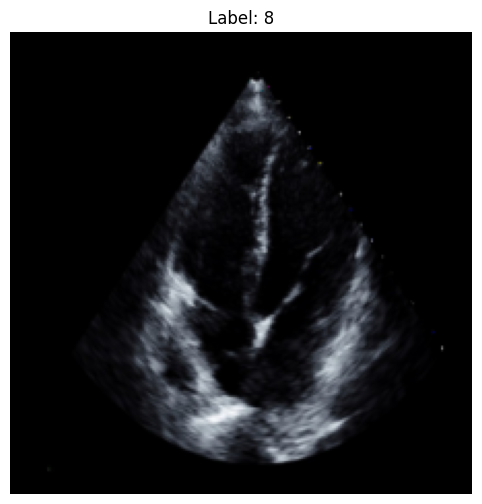

In [14]:
img, label = train_data[97]
visualize_normalized(img, label, avg_data_mean, avg_data_std)

### Create data loaders for the train and validation sets



In [15]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 1, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [16]:
for i,l in train_loader:
    print(i.shape)
    break

torch.Size([32, 3, 224, 224])


### Define the neural network model architecture

In [17]:
view_to_group = {
    0: 'plax',     # PLAX
    1: 'other',    # PSAX-ves
    2: 'psax',     # PSAX-base
    3: 'psax',     # PSAX-mid
    4: 'psax',     # PSAX-apical
    5: 'apical',   # Apical-2ch
    6: 'apical',   # Apical-3ch
    7: 'apical',   # Apical-5ch
    8: 'apical',   # Apical-4ch
    9: 'other',    # Suprasternal
    10: 'other'    # Subcostal
}

group_to_labels = {
    'apical': [5, 6, 7, 8],
    'psax': [ 2, 3, 4],
    'other': [1, 9, 10],
    'plax' : [0]
}

# ----------- Router Model -------------- #
class Router(nn.Module):
    def __init__(self, feature_dim, num_groups = 4):
        super().__init__()
        self.classifier = nn.Linear(feature_dim, num_groups)
        self.group_names = ['apical', 'psax', 'other', 'plax']

    def forward(self, features):
        return self.classifier(features) #[B, 4]

    # def predict_group(self, features):
    #     with torch.no_grad():
    #         group_logits = self.forward(features) #[B, 4]
    #         group_indices = group_logits.argmax(dim=1)  # [B]
    #         return [self.group_names[i] for i in group_indices]

# ------------ Multi-Head Classifier ------------ #
class MultiHeadClassifier(nn.Module):
    def __init__(self, feature_dim, group_to_labels):
        super().__init__()
        self.group_to_labels = group_to_labels
        self.heads = nn.ModuleDict()
        for group, labels in group_to_labels.items():
            self.heads[group] = nn.Linear(feature_dim, len(labels))
        self.group_names = list(group_to_labels.keys())

    def forward(self, features, group_probs):
        logits = torch.zeros(features.size(0), max(max(v) for v in group_to_labels.values()) + 1).to(features.device)
        for i, group in enumerate(self.group_names):
            head = self.heads[group]
            group_logits = head(features)
            mapped_labels = self.group_to_labels[group]
            probs = group_probs[:, i].unsqueeze(1)  # (B, 1)
            for j, view_id in enumerate(mapped_labels):
                logits[:, view_id] += probs.squeeze() * group_logits[:, j]
        return logits


# ------------ Full Model ------------ #
class MultiViewClassifier(nn.Module):
    def __init__(self, backbone_type='convnext_small'):
        super().__init__()
        base = getattr(torchvision.models, backbone_type)(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(base.features, nn.AdaptiveAvgPool2d((1, 1)))
        self.flatten = nn.Flatten()
        self.router = Router(768)
        self.multihead = MultiHeadClassifier(feature_dim=768, group_to_labels=group_to_labels)
        self.view_id_to_group_idx = {
            view_id: self.router.group_names.index(view_to_group[view_id])
            for view_id in range(11)
        }


    def forward(self, x, labels=None):
        x = self.features(x)  # (B, 768, 1, 1)
        x = self.flatten(x)   # (B, 768)
        group_logits = self.router(x)
        group_probs = torch.softmax(group_logits, dim=1)
        view_logits = self.multihead(x, group_probs)
        return view_logits, group_logits
    
backbone_type = 'convnext_small'
model = MultiViewClassifier(backbone_type=backbone_type)

In [17]:
model = MultiViewClassifier(backbone_type="convnext_small")
dummy = torch.randn(2, 3, 224, 224)
model(dummy)

(tensor([[ 0.0455, -0.0463, -0.0002, -0.0820,  0.0283, -0.0067,  0.0179,  0.0340,
           0.0302, -0.0411,  0.0332],
         [ 0.0453, -0.0569, -0.0018, -0.0827,  0.0164, -0.0101,  0.0138,  0.0388,
           0.0203, -0.0361,  0.0230]], grad_fn=<CopySlices>),
 tensor([[-0.2509,  0.0952,  0.1915, -0.1052],
         [-0.1958,  0.0957,  0.1589, -0.0974]], grad_fn=<AddmmBackward0>))

### Freeze initial layers of the model

In [18]:
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

In [19]:
def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

### Define loss and optimizer

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) ## changed from 0.001 to 0.0001 

def update_optimizer(model, new_lr):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=new_lr, weight_decay=1e-5)

print(device)

cuda


### Train the model

In [23]:
def evaluate(model, loader, device, epoch, mode='validation'):
  model.eval()
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      view_logits, group_logits = model(images)
      group_targets = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
      group_loss = criterion(group_logits, group_targets)
      view_loss = criterion(view_logits, labels)
      loss = group_loss + view_loss
      total += images.size(0)
      _, predictions_view = view_logits.max(1)
    _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == labels).sum()
    running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total
  print(f'{mode} epoch {epoch}:  Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  return epoch_acc_group, epoch_acc_view, loss



In [24]:
epochs = 25
backbone_freeze_epoch = 5
val_loss = 0.0
best_val_loss = float('inf')
best_model = None

# freeze_backbone(model)
# print("Backbone frozen.")

for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects_view = 0
  running_corrects_group = 0

  # if epoch == backbone_freeze_epoch:
  #   unfreeze_backbone(model)
  #   update_optimizer(model, new_lr=1e-5)
  #   print("Backbone unfrozen, optimizer updated.")

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    view_logits, group_logits = model(images)
    labels = labels.squeeze(1)
    group_targets = torch.tensor([model.view_id_to_group_idx[v.item()] for v in labels], device=device)
    group_loss = criterion(group_logits, group_targets)
    view_loss = criterion(view_logits, labels)
    loss = group_loss + view_loss
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions_view = view_logits.max(1)
    _, predictions_group = group_logits.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects_view += (predictions_view == labels).sum()
    running_corrects_group += (predictions_group == group_targets).sum()

  epoch_loss = running_loss / total
  epoch_acc_group = running_corrects_group / total
  epoch_acc_view = running_corrects_view / total

  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy Group ({epoch_acc_group:6.5f}), Accuracy View ({epoch_acc_view:6.5f}) )')
  val_acc_group, val_acc_view, val_loss = evaluate(model, val_loader, device, epoch, mode='valid')

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc_view
    best_val_loss = val_loss
    epochs_no_improve = 0
    best_model = copy.deepcopy(model)
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 6 and epoch > 18:
    print('no further improvement ', best_acc)
    break


Train epoch 0: Loss(1.5337, Accuracy Group (0.85082), Accuracy View (0.61884) )
valid epoch 0:  Loss(1.5990, Accuracy Group (0.83301), Accuracy View (0.69922) )
---
Train epoch 1: Loss(1.2005, Accuracy Group (0.88641), Accuracy View (0.71305) )
valid epoch 1:  Loss(1.0488, Accuracy Group (0.88574), Accuracy View (0.77734) )
---
Train epoch 2: Loss(0.9837, Accuracy Group (0.91195), Accuracy View (0.76414) )
valid epoch 2:  Loss(0.8800, Accuracy Group (0.90820), Accuracy View (0.79883) )
---
Train epoch 3: Loss(0.8927, Accuracy Group (0.92130), Accuracy View (0.79562) )
valid epoch 3:  Loss(0.9283, Accuracy Group (0.90527), Accuracy View (0.81250) )
---
Train epoch 4: Loss(0.7676, Accuracy Group (0.93248), Accuracy View (0.82094) )
valid epoch 4:  Loss(1.0175, Accuracy Group (0.90527), Accuracy View (0.81055) )
---
Train epoch 5: Loss(0.7523, Accuracy Group (0.93385), Accuracy View (0.82231) )
valid epoch 5:  Loss(1.1072, Accuracy Group (0.89648), Accuracy View (0.80176) )
---
Train epoc

KeyboardInterrupt: 

In [43]:
model = best_model if best_model != None else model

In [35]:
torch.save({
    'model_name': 'f{model.__class__.__name__}',
    'num_classes': 11,
    'discription': f'trained with {backbone_type} backbone, including {[i.__class__.__name__ for i in train_transform]} in augmentation, images shape is {img.shape}',
    'accuracyOnVal' : round(val_acc_view.item(),3),
    'date': str(datetime.datetime.now()).split('.')[0],
    'state_dict': model.state_dict(),
    'model' : model,
}, os.path.join(files_address, 'notebooks/saved_models', f'model_{model.__class__.__name__}-bb_({backbone_type})-acc_{round(val_acc_view.item(),3)}.pth'))

#### Load a Pretrained Model

In [ ]:
loaded_info = torch.load(os.path.join(files_address, 'notebooks/saved_models', f'model_{model.__class__.__name__}-bb_({backbone_type})-acc_{round(val_acc_view.item(),3)}.pth'))
model = loaded_info['model']
description = loaded_info['discription']
description

# state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
# new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.to(device)
# val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

"trained with convnext_small backbone, including ['RandomHorizontalFlip', 'RandomVerticalFlip', 'RandomRotation', 'RandomApply', 'RandomApply', 'RandomErasing', 'RandomApply'] in augmentation, images shape is torch.Size([3, 224, 224])"

In [20]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs, groups = model(images)
      # loss = criterion(outputs, labels)
      # total_loss += loss.item() * images.size(0)
      total += images.size(0) 
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()

  # print(total_correct, total, accuracy)
  # loss = total_loss / total
  accuracy = total_correct / total
  # print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  print(f'{mode}  Accuracy ({accuracy:6.4f}))')
  return accuracy

evaluate(model, loader= test_loader, device = device)

Test  Accuracy (0.8011))


tensor(0.8011, device='cuda:0')

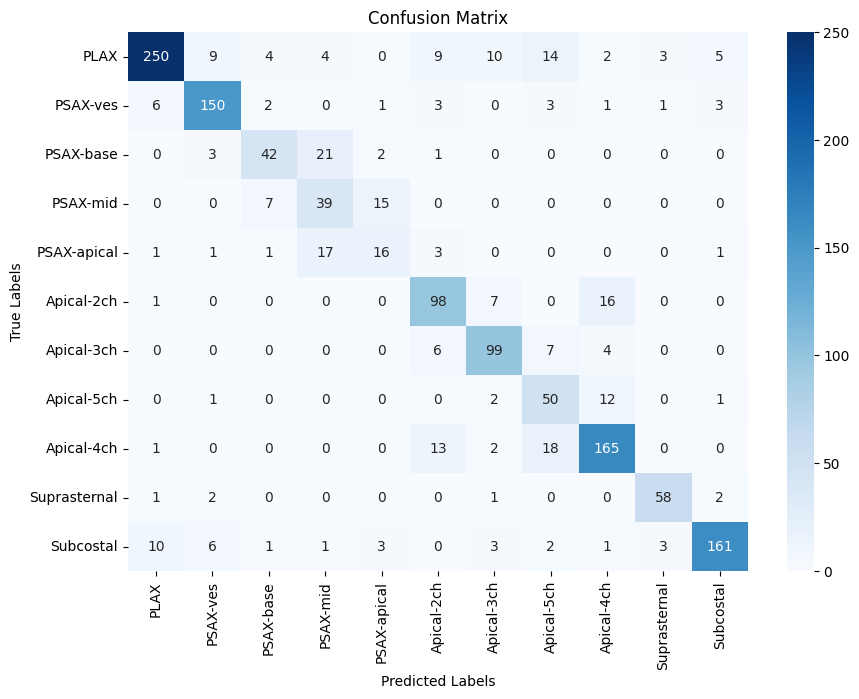

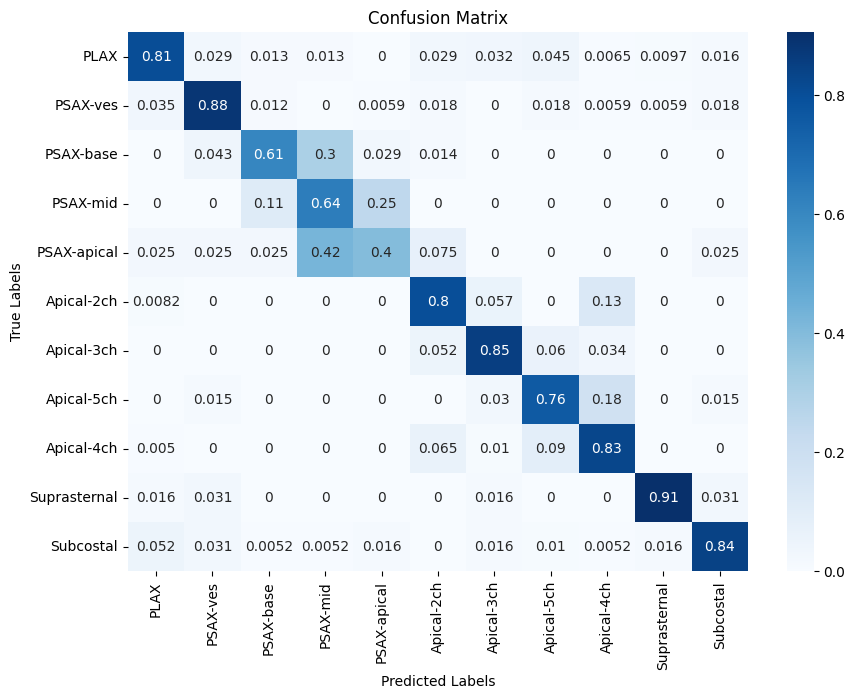

In [21]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs, _ = model(images, labels)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

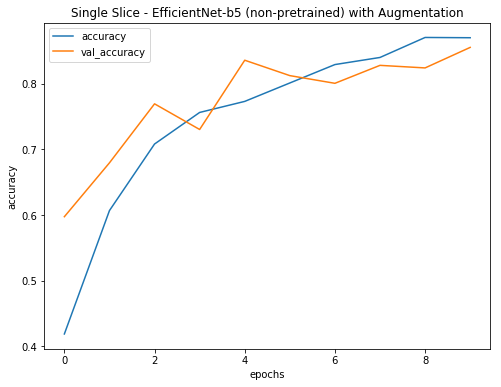

In [ ]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Single Slice - EfficientNet-b5 (non-pretrained) with Augmentation')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels